In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 1000)
sns.set_style("whitegrid")

In [2]:
df = pd.read_csv("../data/raw/dump_ml_data_vacancies.csv")

/tmp/ipykernel_74585/753128051.py:1: DtypeWarning: Columns (32,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/raw/dump_ml_data_vacancies.csv")


### Посмотрим на информацию по всем признакам

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102196 entries, 0 to 102195
Data columns (total 72 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   _id                           102196 non-null  object 
 1   accept_handicapped            102196 non-null  bool   
 2   accept_incomplete_resumes     102196 non-null  bool   
 3   accept_kids                   102196 non-null  bool   
 4   accept_temporary              102196 non-null  bool   
 5   address.building              49308 non-null   object 
 6   address.city                  54946 non-null   object 
 7   address.description           0 non-null       float64
 8   address.lat                   55146 non-null   float64
 9   address.lng                   55146 non-null   float64
 10  address.metro                 0 non-null       float64
 11  address.metro_stations        4351 non-null    object 
 12  address.raw                   56086 non-null

In [4]:
# пересчет начального уровня зарплаты после налогов
df["salary.from"] = df.apply(
    lambda x: x["salary.from"] if x["salary.gross"] == "False" else x["salary.from"] * 0.87,
    axis=1)
# пересчет верхнего уровня зарплаты после налогов
df["salary.to"] = df.apply(
    lambda x: x["salary.to"] if x["salary.gross"] == "False" else x["salary.to"] * 0.87,
    axis=1)

In [5]:
# расчет и добавление средней зарплаты в рублях
df["salary.mean"] = df.apply(lambda x: (x["salary.from"] + x["salary.to"])/2 if x["salary.from"]==x["salary.from"] or x["salary.to"]==x["salary.to"] else np.nan, axis=1)
df["salary.mean"] = df.apply(lambda x: x["salary.mean"] if x["salary.gross"]=="False" else x["salary.mean"]*0.87, axis=1)

### удаление строк с валютной зарплатой

In [6]:
df["salary.currency"].value_counts()

RUR    86755
USD       64
EUR       27
BYR        4
KZT        3
Name: salary.currency, dtype: int64

In [7]:
df = df.drop(df[df["salary.currency"].isin(["USD", "EUR", "BYR", "KZT"])].index)

### удаление колонки валюты и неактуальных признаков зарплаты (кроме salary.mean и salary.gross)

In [8]:
df = df.drop(columns=['salary.currency', 'salary.from', 'salary.to'])

### преобразование географических координат места работы

In [9]:
df.loc[df[df["address.lat"]==0].index.to_list(), "address.lat"] = np.nan
df.loc[df[df["address.lng"]==0].index.to_list(), "address.lat"] = np.nan

### Будем рассматривать каждый признак по отдельности

### id (идентификатор вакансии на сайте HH.ru)

In [10]:
df.id.head(3)

0    69761814
1    69683316
2    70089465
Name: id, dtype: int64

In [11]:
# Посмотрим количество уникальных значений id
df.id.nunique()

102098

In [12]:
# Число уникальных = мощности датасета, для удобства поставим id в качестве индекса
df = df.set_index('id')

In [13]:
df = df.drop(columns=['_id'])

__________________

### description (текстовое описание вакансии)

In [14]:
df[["description"]].head(3)

description
id                                                         
69761814  <p><strong>Приветствуем вас!</strong></p> <p>М...
69683316  <p><strong>Обязанности:</strong></p> <p> </p> ...
70089465  <p>Компания &quot;Обаяние продаж&quot; более 1...

Оставим description без изменений. Для первой итерации модели не будем использовать.

__________________

### key_skills (список ключевых навыков)

In [15]:
df[['key_skills']].sample(3)

key_skills
id                                                         
70877670  [{"name":"Руководство коллективом"},{"name":"У...
69438099  [{"name":"Грамотная речь"},{"name":"Пользовате...
71066553  [{"name":"SQL"},{"name":"СУБД"},{"name":"Базы ...

В признаке вложенный JSON, можно его раскрыть

In [16]:
df['key_skills'] = df.apply(lambda x: eval(x['key_skills']) if isinstance(x['key_skills'], str) else x['key_skills'], axis=1)
df['key_skills'] = df.apply(lambda x: [i['name'] for i in x['key_skills']] if isinstance(x['key_skills'], list) else x['key_skills'], axis=1)
df['key_skills'] = df.apply(lambda x: np.unique(x['key_skills']) if isinstance(x['key_skills'], list) else x['key_skills'], axis=1)

In [17]:
df[['key_skills']].sample(3)

key_skills
id                                                         
70728757  [Грамотная речь, Обучение и развитие, Обучение...
70120529                                                NaN
71010370  [Вождение автомобилей представительского класс...

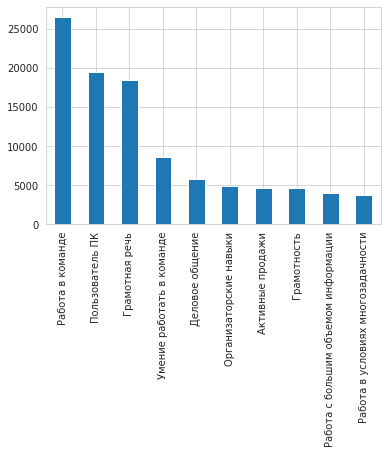

In [18]:
# топ 10 key skills по частоте упоминания в вакансиях
df[['key_skills']].explode(column='key_skills')['key_skills'].value_counts()[:10].plot(kind='bar');

Из признака можно будет сделать векторное представление через word2vec и попробовать использовать его в модели.

__________________

### schedule.name (тип занятости)

In [19]:
df[["schedule.name"]].sample(3)

schedule.name
id                      
70419925   Гибкий график
69031063     Полный день
71092416  Сменный график

In [20]:
df[["schedule.name"]].value_counts()

schedule.name   
Полный день         71448
Сменный график      12762
Вахтовый метод       8068
Удаленная работа     6325
Гибкий график        3495
dtype: int64

5 уникальных значений, признак можно закодировать через OHE

In [21]:
ohe_cols = []
ohe_cols.append("schedule.name")

__________________

### schedule.id (идентификатор типа занятости)

In [22]:
df[["schedule.id"]].value_counts()

schedule.id
fullDay        71448
shift          12762
flyInFlyOut     8068
remote          6325
flexible        3495
dtype: int64

Идентификатор признака schedule.name, нужно убрать

In [23]:
df = df.drop(columns=['schedule.id'])

Сразу уберем все признаки с постфиксом id так как они будут идентификаторами признаков с постфиксом name

In [24]:
df = df.drop(columns=[x for x in df.columns.to_list() if '.id' in x])

__________________

### accept_handicapped (указание, что вакансия доступна для соискателей с инвалидностью)

In [25]:
df[['accept_handicapped']].sample(3)

accept_handicapped
id                          
71220295               False
71128496               False
70840576               False

In [26]:
df[['accept_handicapped']].value_counts()

accept_handicapped
False                 97568
True                   4530
dtype: int64

In [27]:
df.groupby('accept_handicapped')['salary.mean'].describe()

count          mean           std      min       25%  \
accept_handicapped                                                           
False               39437.0  44363.705306  31357.038774   0.7569  24599.25   
True                 2312.0  34552.949878  19936.628945  22.7070  20814.75   

                           50%        75%           max  
accept_handicapped                                       
False               34060.5000  52983.000  618765.75000  
True                29015.7615  46208.745  304828.98615

В среднем, если стоит accept_handicapped, то зарплата будет ниже.

__________________

### accept_kids (указание, что вакансия доступна для соискателей от 14 лет)

In [28]:
df[['accept_kids']].sample(3)

accept_kids
id                   
69246773        False
55860218        False
71192225        False

In [29]:
df[['accept_kids']].value_counts()

accept_kids
False          101938
True              160
dtype: int64

In [30]:
df.groupby('accept_kids')['salary.mean'].describe()

count          mean           std       min         25%  \
accept_kids                                                              
False        41651.0  43857.293678  30931.087965    0.7569  24599.2500   
True            98.0  28140.074541  18362.284340  681.2100  15989.5125   

                 50%         75%        max  
accept_kids                                  
False        34060.5  52983.0000  618765.75  
True         22707.0  39264.1875   90828.00

В среднем, если accept_kids (те вакансия для детей), то зарплата у вакансии ниже будет ниже.

__________________

### experience.name (название требуемого опыта работы)

In [31]:
df['experience.name'].sample(3)

id
71090075    От 1 года до 3 лет
69297702         От 3 до 6 лет
71041894             Нет опыта
Name: experience.name, dtype: object

In [32]:
df[["experience.name"]].value_counts()

experience.name   
От 1 года до 3 лет    45712
Нет опыта             40539
От 3 до 6 лет         14290
Более 6 лет            1557
dtype: int64

4 уникальных значения, можем закодировать через OE, так как есть зависимость в годах.

In [33]:
oe_cols = []
oe_cols.append("experience.name")

__________________

### address.building (номер строения в адресе места работы)

In [34]:
df['address.building'].sample(3)

id
70957923    NaN
70425143    NaN
70098163    NaN
Name: address.building, dtype: object

Можно использовать в сочетании с address.city.

In [35]:
df['address.full'] = df.apply(lambda x: str(x['address.city']) + ' ' + str(x['address.building']),axis=1)

In [36]:
df['address.full'].sample(3)

id
71260331       Волгоград 5
68183284           nan nan
69832324    Владивосток 41
Name: address.full, dtype: object

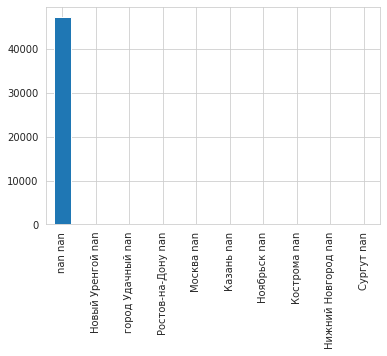

In [37]:
# топ 10 address.full 
df[['address.full']].explode(column='address.full')['address.full'].value_counts()[:10].plot(kind='bar');

Чаще всего встречаются nan. Удалим  `address.full` и `address.building`.

In [38]:
df = df.drop(columns=['address.full', 'address.building'])

_____________

### address.city (город места работы)

In [39]:
df['address.city'].sample(3)

id
71199533    Москва
70581463       NaN
70528694       NaN
Name: address.city, dtype: object

In [40]:
df['address.city'].value_counts()

Новосибирск                1413
Санкт-Петербург            1407
Омск                       1341
Пермь                      1320
Нижний Новгород            1288
                           ... 
Красная Горбатка              1
Никологоры                    1
деревня Большой Приклон       1
поселок Муромцево             1
поселок Ганино                1
Name: address.city, Length: 2919, dtype: int64

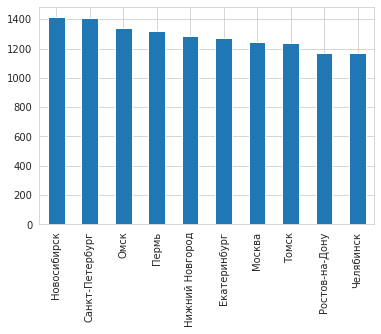

In [41]:
# топ 10 городов 
df[['address.city']].explode(column='address.city')['address.city'].value_counts()[:10].plot(kind='bar');

Города парсились равномерно, перекоса в сторону Москвы нет. Можно закодировать через target encoder.

In [42]:
te_cols = []
te_cols.append('address.city')

_____________

### address.metro (ближайшее к месту работы метро)

In [43]:
df['address.metro'].unique()

array([nan])

Содержит только `NaN`. Можно удалить.

### address.metro_stations (ближайшее к месту работы метро)

In [44]:
df['address.metro_stations'].value_counts()[:10]

[{"station_name":"Горьковская","line_name":"Автозаводская","station_id":"50.278","line_id":"50","lat":56.313933,"lng":43.99482}]         324
[{"station_name":"Площадь Ленина","line_name":"Ленинская","station_id":"52.297","line_id":"52","lat":55.029941,"lng":82.92069}]          142
[{"station_name":"Геологическая","line_name":"Север-Юг","station_id":"48.267","line_id":"48","lat":56.826715,"lng":60.603754}]           124
[{"station_name":"Алабинская","line_name":"Первая","station_id":"54.509","line_id":"54","lat":53.209689,"lng":50.134417}]                124
[{"station_name":"площадь Карла Маркса","line_name":"Ленинская","station_id":"52.301","line_id":"52","lat":54.982931,"lng":82.89313}]    107
[{"station_name":"Площадь Тукая","line_name":"Центральная","station_id":"49.273","line_id":"49","lat":55.787163,"lng":49.122126}]         87
[{"station_name":"Площадь 1905 года","line_name":"Север-Юг","station_id":"48.266","line_id":"48","lat":56.837982,"lng":60.59734}]         87
[{"station_na

Содержит адреса станций метро, расположенных рядом с местом работы.

### address.raw (адрес места работы)

In [45]:
df['address.raw'].value_counts()[:10]

город Удачный                       92
Новый Уренгой                       50
Кострома                            44
Курган, улица Ястржембского, 41А    44
Губкинский                          44
Сургут                              43
Ижевск, улица Карла Маркса, 246     43
Владикавказ                         39
Иваново, Кохомское шоссе, 1Д        36
Псков, улица Белинского, 74         35
Name: address.raw, dtype: int64

<AxesSubplot: >

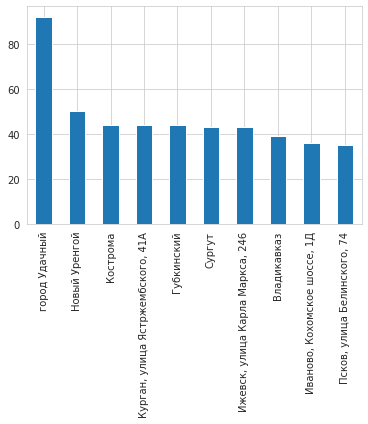

In [46]:
# топ 10 адресов
df[['address.raw']].explode(column='address.raw')['address.raw'].value_counts()[:10].plot(kind='bar')

### address.street (улица)

In [47]:
df['address.street'].value_counts()[:10]

проспект Ленина       894
Советская улица       759
улица Ленина          675
улица Карла Маркса    455
Московское шоссе      363
Промышленная улица    341
Московская улица      272
улица Куйбышева       259
улица Кирова          254
проспект Мира         251
Name: address.street, dtype: int64

<AxesSubplot: >

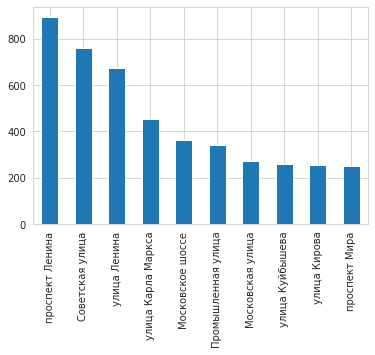

In [48]:
# топ 10 улиц
df[['address.street']].explode(column='address.street')['address.street'].value_counts()[:10].plot(kind='bar')

### employer.alternate_url (ссылка на представление вакансии на сайте)

In [49]:
df["employer.alternate_url"].sample(3)

id
70709083    https://hh.ru/employer/1942330
70694408     https://hh.ru/employer/910582
69497641     https://hh.ru/employer/641397
Name: employer.alternate_url, dtype: object

Содержит URL-ссылку на вакансию. Признак можно удалить.

### employer.name (название компании работодателя)

In [50]:
df["employer.name"].value_counts()[:10]

Яндекс                                    2709
Пятёрочка                                 1431
МАГНИТ, Розничная сеть                    1109
Консалтинг Групп                           920
Тинькофф                                   798
ГБУЗ ТО Областная больница №4 (г.Ишим)     680
Ростелеком                                 665
СБЕР                                       625
Почта России                               550
Сеть языковых школ FRIENDS                 432
Name: employer.name, dtype: int64

<AxesSubplot: >

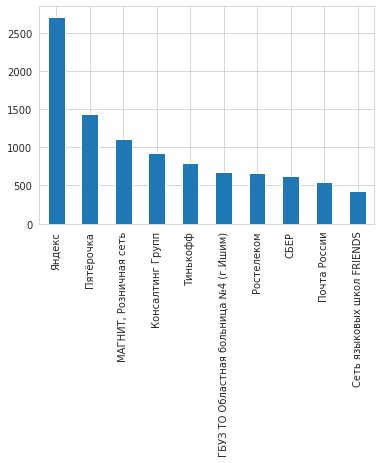

In [51]:
# топ 10 работодателей
df[['employer.name']].explode(column='employer.name')['employer.name'].value_counts()[:10].plot(kind='bar')

### employer.logo_urls

In [52]:
df[~df['employer.logo_urls'].isnull()]['employer.logo_urls']

id
69313857    [object Object]
69314349    [object Object]
70966795    [object Object]
70966796    [object Object]
69604070    [object Object]
Name: employer.logo_urls, dtype: object

Всего 5 объектов с непустым значением. Данный атрибут содержит ссылку на логотип компании-работодателя. Признак можно удалить.

In [53]:
df = df.drop(columns=["employer.logo_urls"])

### employer.url (ссылка на профиль работодателя)

In [54]:
df["employer.url"].sample(3)

id
70029575    https://api.hh.ru/employers/3567294
70817865     https://api.hh.ru/employers/780654
71038411    https://api.hh.ru/employers/2680390
Name: employer.url, dtype: object

Содержит ссылку на работодателя. Признак можно удалить.

In [55]:
df = df.drop(columns=["employer.url"])

### employer.vacancies_url (ссылка на список вакансий работодателя)

In [56]:
df["employer.vacancies_url"].sample(3)

id
71028920      https://api.hh.ru/vacancies?employer_id=49357
70353430    https://api.hh.ru/vacancies?employer_id=1725064
66546052    https://api.hh.ru/vacancies?employer_id=3711595
Name: employer.vacancies_url, dtype: object

Содержит ссылку на вакансии работодателя. Признак можно удалить.

In [57]:
df = df.drop(columns=["employer.vacancies_url"])

### hidden (удалена ли вакансия (скрыта из архива))

In [58]:
df["hidden"].value_counts()

False    102098
Name: hidden, dtype: int64

Все значения одинаковые. Означает, что все вакансии в наборе были открыты на сайте. Признак можно удалить.

In [59]:
df = df.drop(columns=["hidden"])

### initial_created_at (дата и время создания вакансии)

In [60]:
df["initial_created_at"].value_counts()[:10]

2022-10-04T09:02:10+0300    50
2022-09-29T18:29:57+0300    50
2022-10-04T09:11:03+0300    49
2022-09-29T18:23:41+0300    45
2022-10-07T05:07:47+0300    43
2022-10-07T05:13:41+0300    41
2022-09-23T18:45:07+0300    40
2022-10-04T10:30:10+0300    39
2022-10-04T09:08:24+0300    39
2022-09-19T21:23:53+0300    37
Name: initial_created_at, dtype: int64

In [61]:
df["initial_created_at"].min()

'2015-09-25T10:15:01+0300'

In [62]:
df["initial_created_at"].max()

'2022-10-18T18:07:23+0300'

Содержит дату и время создания вакансии.

### name (название вакансии)

In [63]:
df["name"].describe()

count                             102098
unique                             42417
top       Менеджер по работе с клиентами
freq                                 999
Name: name, dtype: object

Содержит название вакансии. Может понадобиться на этапе DL.

### negotiations_url (ссылка на переписку (отклики/приглашения) для работодателя)

In [64]:
df["negotiations_url"].unique()

array([nan])

 Содержит только значения `NaN`. Признак можно удалить.

In [65]:
df = df.drop(columns=["negotiations_url"])

### quick_responses_allowed (разрешены ли быстрые отклики)

In [66]:
df["quick_responses_allowed"].unique()

array([False])

Содержит только значения `False`. Признак можно удалить.

In [67]:
df = df.drop(columns=["quick_responses_allowed"])

### relations (находится ли работодатель в черном списке)

In [68]:
df["relations"].unique()

array(['[]'], dtype=object)

Содержит пустой список. Признак можно удалить.

In [69]:
df = df.drop(columns=["relations"])

### suitable_resumes_url (подходящие резюме на вакансию)

In [70]:
df["suitable_resumes_url"].unique()

array([nan])

Содержит только значения `NaN`. Признак можно удалить.

In [71]:
df = df.drop(columns=["suitable_resumes_url"])

### vacancy_constructor_template (шаблон для создания вакансии)

In [72]:
df["vacancy_constructor_template"].unique()

array([nan])

Содержит только значения `NaN`. Признак можно удалить.

In [73]:
df = df.drop(columns=["vacancy_constructor_template"])

### alternate_url (URL вакансии)

In [74]:
df["alternate_url"].sample(3)

id
70907119    https://hh.ru/vacancy/70907119
71098441    https://hh.ru/vacancy/71098441
70965684    https://hh.ru/vacancy/70965684
Name: alternate_url, dtype: object

In [75]:
# признак нужно убрать

In [76]:
df = df.drop(columns=["alternate_url"])

__________

### apply_alternate_url (ссылка на отклик на вакансию на сайте)

In [77]:
df["apply_alternate_url"].sample(3)

id
70565486    https://hh.ru/applicant/vacancy_response?vacan...
69946608    https://hh.ru/applicant/vacancy_response?vacan...
69972996    https://hh.ru/applicant/vacancy_response?vacan...
Name: apply_alternate_url, dtype: object

In [78]:
df["apply_alternate_url"].nunique()

102098

In [79]:
# признак можно убрать, все уникальные

In [80]:
df = df.drop(columns=["apply_alternate_url"])

___________

### code (внутренний код вакансии работадателя)

In [81]:
df["code"].sample(3)

id
70527535    NaN
70441735    NaN
69961907    NaN
Name: code, dtype: object

In [82]:
df["code"].value_counts()

коптз1                                  121
сгппмд                                   50
ссппзтя                                  35
нктпя360                                 35
code 4135092                             18
                                       ... 
code 4159448                              1
a066df4e-0906-440c-8036-32e7cb725800      1
23f42323-f819-4a3f-b3f4-ac4259c15cfe      1
7bd2db3f-4ec4-4b69-812c-b759719eb1d9      1
e05364ab-c264-414c-81c7-628f703ab7fa      1
Name: code, Length: 1408, dtype: int64

In [83]:
# признак можно убрать, все значения формируются работодателем не системно

In [84]:
df = df.drop(columns=["code"])

___________

### department.name (департамент, от имени которого размещается вакансия)

In [85]:
df['department.name'].sample(3)

id
71005150                    NaN
69069344    ПАО «Газпром нефть»
71064514                    NaN
Name: department.name, dtype: object

<AxesSubplot: >

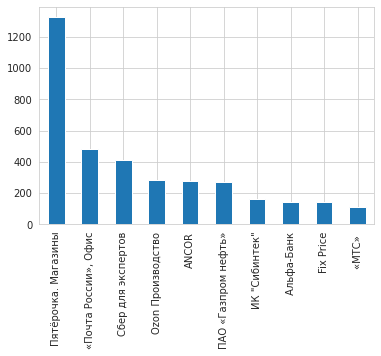

In [86]:
df['department.name'].value_counts()[:10].plot(kind='bar')

In [87]:
# Идентификатор департамента. Высокая кардиналость, признак можно закадировать черзе count encoder

In [88]:
ce_cols = []
ce_cols.append('department.name')

__________

### employment.name (Название типа занятости)

In [89]:
df['employment.name'].sample(3)

id
69909177    Полная занятость
71077055    Полная занятость
71198797    Полная занятость
Name: employment.name, dtype: object

In [90]:
df['employment.name'].value_counts()

Полная занятость       95324
Частичная занятость     5804
Стажировка               626
Проектная работа         342
Волонтерство               2
Name: employment.name, dtype: int64

5 уникальных значений, признак можно закодировать через OHE.

In [91]:
ohe_cols.append("employment.name")

<AxesSubplot: xlabel='employment.name'>

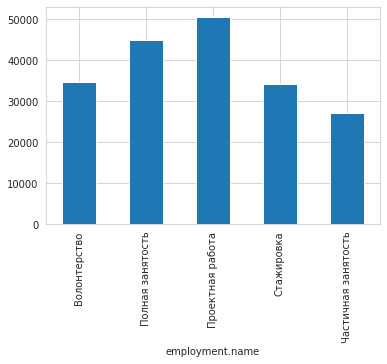

In [92]:
# график зависимости зарплаты от типа занятости
df.groupby('employment.name')['salary.mean'].mean().plot(kind="bar")

<AxesSubplot: xlabel='employment.name'>

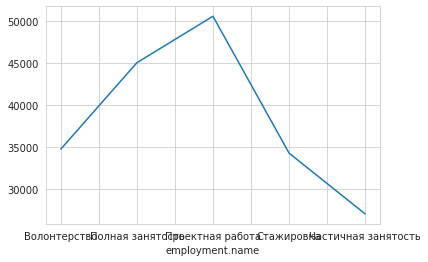

In [93]:
# график зависимости зарплаты от типа занятости
df.groupby("employment.name")["salary.mean"].mean().plot(x='created_at_week', y='salary.mean')

_____________

### archived (находится ли данная вакансия в архиве)

In [94]:
df['archived'].value_counts()

False    102012
True         86
Name: archived, dtype: int64

Признак можно удалить.

In [95]:
df = df.drop(columns=['archived'])

____________________

### insider_interview (интервью о жизни в компании)

In [96]:
df['insider_interview'].sample()

id
67649212   NaN
Name: insider_interview, dtype: float64

In [97]:
df = df.drop(columns = ['insider_interview'])

### area.name (название региона)

In [98]:
df['area.name'].sample(3)

id
70683388     Барнаул
70931279      Казань
70923717    Кострома
Name: area.name, dtype: object

In [99]:
df['area.name'].value_counts()

Санкт-Петербург    2408
Новосибирск        2288
Москва             2272
Омск               2224
Нижний Новгород    2121
                   ... 
Добрунь               1
Харабали              1
Судак                 1
Ерофей Павлович       1
Нолинск               1
Name: area.name, Length: 1917, dtype: int64

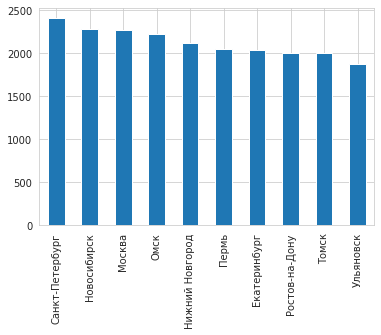

In [100]:
df[['area.name']].explode(column='area.name')['area.name'].value_counts()[:10].plot(kind='bar');

Похож на `address.city` можно закодировать через target encoder.

In [101]:
te_cols = []
te_cols.append('area.name')

### area_url (URL получения информации о регионе)

In [102]:
df['area.url'].value_counts()

https://api.hh.ru/areas/2       2408
https://api.hh.ru/areas/4       2288
https://api.hh.ru/areas/1       2272
https://api.hh.ru/areas/68      2224
https://api.hh.ru/areas/66      2121
                                ... 
https://api.hh.ru/areas/4047       1
https://api.hh.ru/areas/1510       1
https://api.hh.ru/areas/2383       1
https://api.hh.ru/areas/5214       1
https://api.hh.ru/areas/1671       1
Name: area.url, Length: 1917, dtype: int64

In [103]:
df = df.drop(columns=['area.url'])

___________

### created_at (дата и время публикации вакансии)

In [104]:
df['created_at'].min()

'2022-07-15T13:28:48+0300'

In [105]:
df['created_at'].max()

'2022-10-18T18:45:22+0300'

Спарсили данных на 3 месяца.

/tmp/ipykernel_74585/208918723.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['created_at_week'] = df['created_at'].dt.week


array([<AxesSubplot: xlabel='created_at_week'>,
       <AxesSubplot: xlabel='created_at_week'>,
       <AxesSubplot: xlabel='created_at_week'>,
       <AxesSubplot: xlabel='created_at_week'>,
       <AxesSubplot: xlabel='created_at_week'>], dtype=object)

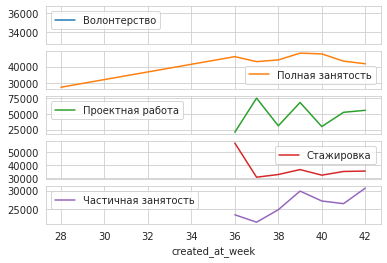

In [106]:
# преобразование строки в тип даты и времени
df['created_at'] =  pd.to_datetime(df['created_at'])
# группировка по временным диапазонам
df['created_at_week'] = df['created_at'].dt.week
df['created_at_month'] = df['created_at'].dt.month
# графики зарплат по видам занятости
pd.pivot_table(df.reset_index(),
    index='created_at_week', columns='employment.name', values='salary.mean'
).plot(subplots= True )

<AxesSubplot: xlabel='created_at_week'>

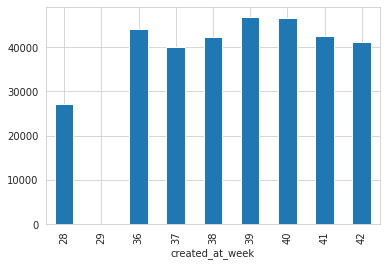

In [107]:
# график зарплаты от created_at
df.groupby('created_at_week')['salary.mean'].mean().plot(kind="bar")

_________

### published_at (дата и время публикации вакансии)

In [108]:
df['published_at'].min()

'2022-07-15T13:28:48+0300'

In [109]:
df['published_at'].max()

'2022-10-18T18:45:22+0300'

In [110]:
df = df.drop(columns=['published_at'])

___________________

### employer.trusted (прошел ли работодатель верификацию на сайте)

In [111]:
df['employer.trusted'].sample(3)

id
70888771    True
70461289    True
70757060    True
Name: employer.trusted, dtype: bool

In [112]:
df.groupby('employer.trusted')['salary.mean'].describe()

count          mean           std      min       25%  \
employer.trusted                                                           
False              1578.0  38946.711599  24428.792861  22.7070  24599.25   
True              40171.0  44011.848233  31128.752868   0.7569  24599.25   

                       50%       75%        max  
employer.trusted                                 
False             32168.25  45792.45  238423.50  
True              34060.50  52983.00  618765.75

<AxesSubplot: xlabel='employer.trusted'>

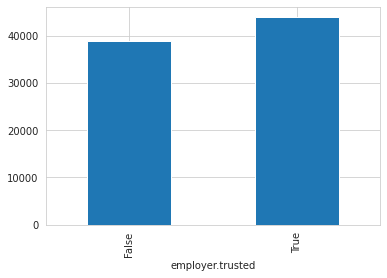

In [113]:
# график зарплаты от employer.trusted
df.groupby('employer.trusted')['salary.mean'].mean().plot(kind="bar")

array([<AxesSubplot: xlabel='created_at_week'>,
       <AxesSubplot: xlabel='created_at_week'>], dtype=object)

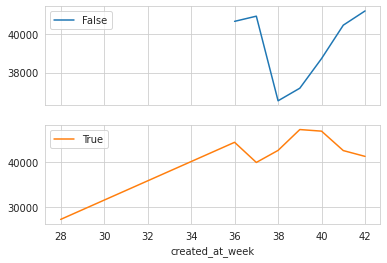

In [114]:
pd.pivot_table(df.reset_index(),
    index='created_at_week', columns='employer.trusted', values='salary.mean'
).plot(subplots= True )

Уровень средней зарплаты выше у работодателей с верификацией на сайте HH.ru.

___________________

### response_letter_required (обязательно ли заполнять сообщение при отклике на вакансию)

In [115]:
df['response_letter_required'].value_counts()

False    101217
True        881
Name: response_letter_required, dtype: int64

In [116]:
df.groupby('response_letter_required')['salary.mean'].describe()

count          mean           std        min  \
response_letter_required                                                   
False                     41308.0  43821.409116  30930.840361     0.7569   
True                        441.0  43725.846969  29605.201823  1400.2650   

                               25%       50%       75%        max  
response_letter_required                                           
False                     24599.25  34060.50  52983.00  618765.75  
True                      26869.95  35952.75  51090.75  245992.50

Почти нет разницы в средних зарплатах.

____________

### type.name (название типа вакансии)

In [117]:
df['type.name'].sample(3)

id
71145199    Открытая
70391933    Открытая
68303094    Открытая
Name: type.name, dtype: object

In [118]:
df['type.name'].value_counts()

Открытая     101848
Анонимная       204
Рекламная        46
Name: type.name, dtype: int64

In [119]:
ohe_cols.append('type.name')

___________________

### has_test (информация о наличии прикрепленного тестового задании к вакансии)

In [120]:
df['has_test'].sample(3)

id
70441876    False
70688459    False
68741295    False
Name: has_test, dtype: bool

In [121]:
df['has_test'].value_counts()

False    101274
True        824
Name: has_test, dtype: int64

In [122]:
df.groupby('has_test')['salary.mean'].describe()

count          mean           std        min       25%       50%  \
has_test                                                                       
False     41512.0  43788.829582  30914.972217     0.7569  24599.25  34060.50   
True        237.0  49350.095573  30803.463320  3368.2050  28383.75  39737.25   

              75%        max  
has_test                      
False     52983.0  618765.75  
True      60552.0  177871.50

Средняя зарплата выше если есть тестовое.

___________

### response_url (URL для отклика на сайте работодателя)

In [123]:
df['response_url'].value_counts()

https://hh.ru/vrsurvey/tmk_tokar?utm_source=hh_lead_gen&utm_medium=VHR&utm_campaign=tmk_tokar                   13
https://hh.ru/article/30525?utm_source=hh_lead_gen&utm_medium=cpc&utm_campaign=X5_kladovshik_newriga_premium     7
https://hh.ru/article/28280?utm_source=hh_lead_gen&utm_medium=VHR&utm_campaign=X5_kassir_rf_premium              7
https://hh.ru/article/24852?utm_source=hh_lead_gen&utm_medium=cpc&utm_campaign=X5_director_premium               3
https://hh.ru/article/30856?utm_source=hh_lead_gen&utm_medium=vhr&utm_campaign=vit_nightstaff                    3
https://hh.ru/vacancy/69590738                                                                                   1
https://vrsurvey.hh.ru/samokat_courier?utm_source=hh_lead_gen&utm_medium=VHR&utm_campaign=samokat_kurier         1
https://hh.ru/vacancy/69703673                                                                                   1
https://hh.ru/vacancy/69421106                                                  

In [124]:
df = df.drop(columns=['response_url'])

_____________

### test (информация о прикрепленном тестовом задании к вакансии)

In [125]:
df['test'].value_counts()

Series([], Name: test, dtype: int64)

In [126]:
df = df.drop(columns=['test'])

______________

### specializations (специализации)

In [127]:
df['specializations'].sample(3)

id
70417325    [{"id":"17.242","name":"Прямые продажи","profa...
70345898    [{"id":"21.17","name":"Автоперевозки","profare...
71194849    [{"id":"17.242","name":"Прямые продажи","profa...
Name: specializations, dtype: object

In [128]:
df['specializations'] = df.apply(lambda x: eval(x['specializations']) if isinstance(x['specializations'], str) else x['specializations'], axis=1)
df['specializations.id'] = df.apply(lambda x: [i['name'] for i in x['specializations']] if isinstance(x['specializations'], list) else x['specializations'], axis=1)
df['specializations.profarea_id'] = df.apply(lambda x: [i['profarea_name'] for i in x['specializations']] if isinstance(x['specializations'], list) else x['specializations'], axis=1)

In [129]:
df = df.drop(columns=['specializations'])

### specializations.id (идентификатор специализации)

In [130]:
df['specializations.id'].value_counts()[:10]

[Розничная торговля, Прямые продажи, Менеджер по работе с клиентами, Начальный уровень, Мало опыта, Продажи]         9431
[Прямые продажи, Оптовая торговля, Менеджер по работе с клиентами]                                                   5756
[Розничная торговля, Начальный уровень, Мало опыта, Торговые сети, Продавец в магазине, Продажи]                     5118
[Автоперевозки, Водитель, Логистика, Экспедитор]                                                                     4634
[Начальный уровень, Мало опыта, Системный администратор, Инженер, Поддержка, Helpdesk, Интернет]                     3630
[Программирование, Разработка, Системы управления предприятием (ERP), Инженер, Web инженер, Web мастер]              3183
[Бухгалтер, Учет заработной платы, Бухгалтер-калькулятор, Учет счетов и платежей, Первичная документация]            2953
[Администрация, Управляющий офисом (Оffice manager), Ресепшен, Начальный уровень, Мало опыта, Розничная торговля]    2932
[Грузчик, Комплектовщик,

Из признака можно будет сделать векторное представление через word2vec и попробовать использовать его в модели.

____________

### specializations.profarea_id (идентификатор профессиональной области, в которую входит специализация)

In [131]:
df['specializations.profarea_id'].value_counts()[:10]

[Продажи, Продажи, Продажи, Продажи, Начало карьеры, студенты]                                                                                                                                                                                                                         15193
[Информационные технологии, интернет, телеком, Информационные технологии, интернет, телеком, Информационные технологии, интернет, телеком, Информационные технологии, интернет, телеком, Информационные технологии, интернет, телеком]                                                  8543
[Транспорт, логистика, Транспорт, логистика, Транспорт, логистика, Транспорт, логистика]                                                                                                                                                                                                6512
[Продажи, Продажи, Продажи]                                                                                                                      

Из признака можно будет сделать векторное представление через word2vec и попробовать использовать его в модели.

______________

### contacts (контактная информация)

In [132]:
df['contacts'].value_counts()

Series([], Name: contacts, dtype: int64)

In [133]:
df = df.drop(columns='contacts')

____________

### billing_type.name (название биллингового типа вакансии)

In [134]:
df['billing_type.name'].value_counts()

Стандарт         95089
Стандарт плюс     6915
Премиум             94
Name: billing_type.name, dtype: int64

In [135]:
ohe_cols.append("billing_type.name")

________

### allow_messages (включена ли возможность соискателю писать сообщения работодателю, после приглашения/отклика на вакансию)

In [136]:
df['allow_messages'].value_counts()

True     94070
False     8028
Name: allow_messages, dtype: int64

In [137]:
df.groupby('allow_messages')['salary.mean'].describe()

count          mean           std      min       25%  \
allow_messages                                                           
False            4324.0  36903.108756  25947.080740  30.2760  22707.00   
True            37425.0  44619.607856  31342.471947   0.7569  24599.25   

                    50%       75%        max  
allow_messages                                
False           29519.1  41629.50  439002.00  
True            34060.5  53361.45  618765.75

Более общительные работодатели платят больше.

________

### premium (является ли данная вакансия премиум-вакансией)

In [138]:
df['premium'].value_counts()

False    102004
True         94
Name: premium, dtype: int64

In [139]:
df.groupby('premium')['salary.mean'].describe()

count          mean           std         min        25%  \
premium                                                               
False    41717.0  43811.837763  30912.151069      0.7569  24599.250   
True        32.0  54982.197605  35276.927086  25734.6000  33114.375   

               50%          75%        max  
premium                                     
False    34060.500  52983.00000  618765.75  
True     44467.875  58186.30905  189225.00

___________

У premium вакансий средняя зарплата выше.

### driver_license_types (список требуемых категорий водительских прав)

In [140]:
df['driver_license_types'].value_counts()[:10]

[]                                     100245
[{"id":"B"}]                              839
[{"id":"B"},{"id":"C"}]                   310
[{"id":"C"}]                              212
[{"id":"D"}]                               70
[{"id":"C"},{"id":"E"},{"id":"CE"}]        47
[{"id":"CE"}]                              38
[{"id":"E"}]                               36
[{"id":"B"},{"id":"C"},{"id":"D"}]         36
[{"id":"C"},{"id":"E"}]                    33
Name: driver_license_types, dtype: int64

In [141]:
df['driver_license_types'] = df.apply(lambda x: eval(x['driver_license_types']) if isinstance(x['driver_license_types'], str) else x['driver_license_types'], axis=1)
df['driver_license_types.name'] = df.apply(lambda x: [i['id'] for i in x['driver_license_types']] if isinstance(x['driver_license_types'], list) else x['driver_license_types'], axis=1)


In [142]:
df['driver_license_types.name'].value_counts()[:10]

[]            100245
[B]              839
[B, C]           310
[C]              212
[D]               70
[C, E, CE]        47
[CE]              38
[E]               36
[B, C, D]         36
[C, E]            33
Name: driver_license_types.name, dtype: int64

In [143]:
df = df.drop(columns=['driver_license_types'])

Из признака можно будет сделать векторное представление через word2vec и попробовать использовать его в модели.

________

### accept_incomplete_resumes (разрешен ли отклик на вакансию неполным резюме)

In [144]:
df['accept_incomplete_resumes'].value_counts()

False    63315
True     38783
Name: accept_incomplete_resumes, dtype: int64

In [145]:
df.groupby('accept_incomplete_resumes')['salary.mean'].describe()

count          mean           std       min  \
accept_incomplete_resumes                                                  
False                      23800.0  45983.303464  33003.197624   0.75690   
True                       17949.0  40952.434332  27652.010946  12.48885   

                                    25%          50%      75%        max  
accept_incomplete_resumes                                                 
False                      25400.712487  35512.61265  56767.5  618765.75  
True                       23187.631500  32168.25000  49198.5  401157.00

Заполни резюме и получай больше денег ;)

________

### working_days (рабочие дни)

In [146]:
df['working_days'].value_counts()

[]                                                                       100489
[{"id":"only_saturday_and_sunday","name":"Работа только по сб и вс"}]      1609
Name: working_days, dtype: int64

In [147]:
df['working_days'] = df.apply(lambda x: True if len(x['working_days'])>2 else False,axis=1)

In [148]:
df['working_days'].value_counts()

False    100489
True       1609
Name: working_days, dtype: int64

In [149]:
df.groupby('working_days')['salary.mean'].describe()

count          mean           std      min       25%  \
working_days                                                           
False         40915.0  43918.565679  31059.037043   0.7569  24599.25   
True            834.0  39004.498196  22367.742210  30.2760  22707.00   

                      50%       75%        max  
working_days                                    
False         34060.50000  52983.00  618765.75  
True          34879.84425  54875.25  170302.50

Работа только на выходных оплачивается меньше.

_____________

### working_time_intervals (временные интервалы работы)

In [150]:
df['working_time_intervals'].value_counts()

[]                                                                                                97103
[{"id":"from_four_to_six_hours_in_a_day","name":"Можно работать сменами по 4–6 часов в день"}]     4995
Name: working_time_intervals, dtype: int64

In [151]:
df['working_time_intervals'] = df.apply(lambda x: True if len(x['working_time_intervals'])>2 else False,axis=1)

In [152]:
df['working_time_intervals'].value_counts()

False    97103
True      4995
Name: working_time_intervals, dtype: int64

In [153]:
df.groupby('working_time_intervals')['salary.mean'].describe()

count          mean           std      min  \
working_time_intervals                                                 
False                   38700.0  44732.682900  31466.523077   0.7569   
True                     3049.0  32241.075125  19392.220318  30.2760   

                              25%      50%      75%        max  
working_time_intervals                                          
False                   24599.250  34060.5  52983.0  618765.75  
True                    19944.315  27248.4  39358.8  208147.50

Работа по интервалам оплачивается меньше.

___________________

### working_time_modes (режимы времени работы)

In [154]:
df['working_time_modes'].value_counts()

[]                                                                             98158
[{"id":"start_after_sixteen","name":"Можно начинать работать после 16:00"}]     3940
Name: working_time_modes, dtype: int64

In [155]:
df['working_time_modes'] = df.apply(lambda x: True if len(x['working_time_modes'])>2 else False,axis=1)

In [156]:
df.groupby('working_time_modes')['salary.mean'].describe()

count          mean           std      min       25%  \
working_time_modes                                                           
False               39333.0  44530.902507  31328.312002   0.7569  24599.25   
True                 2416.0  32253.260741  19924.628253  30.2760  19679.40   

                        50%      75%        max  
working_time_modes                               
False               34060.5  52983.0  618765.75  
True                25734.6  41629.5  170302.50

Работа позже 16 оплачивается меньше.

_________________

### accept_temporary (указание, что вакансия доступна для соискателей с временным трудоустройством)

In [157]:
df['accept_temporary'].value_counts()

False    93851
True      8247
Name: accept_temporary, dtype: int64

In [158]:
df.groupby('accept_temporary')['salary.mean'].describe()

count          mean           std      min       25%  \
accept_temporary                                                           
False             37183.0  42874.510007  30427.039211   0.7569  24599.25   
True               4566.0  51523.206456  33676.835174  56.7675  26491.50   

                       50%       75%        max  
accept_temporary                                 
False             33227.91  51090.75  618765.75  
True              41629.50  68121.00  491985.00

_________________

### professional_roles (массив объектов профролей)

In [159]:
df['professional_roles'].sample(3)

id
70334027           [{"id":"28","name":"Геолог"}]
70109096    [{"id":"145","name":"Юрисконсульт"}]
69978969         [{"id":"90","name":"Охранник"}]
Name: professional_roles, dtype: object

In [160]:
df['professional_roles'] = df.apply(lambda x: eval(x['professional_roles']) if isinstance(x['professional_roles'], str) else x['professional_roles'], axis=1)
df['professional_roles.name'] = df.apply(lambda x: [i['name'] for i in x['professional_roles']] if isinstance(x['professional_roles'], list) else x['professional_roles'], axis=1)


<AxesSubplot: >

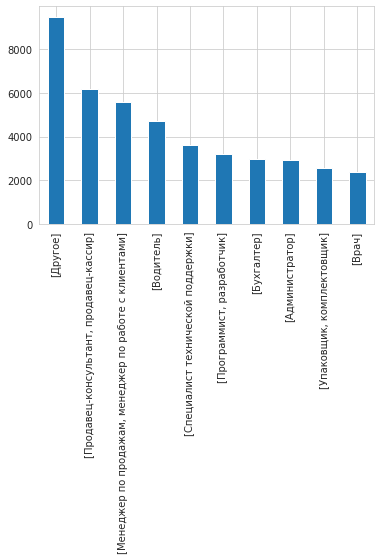

In [161]:
df['professional_roles.name'].value_counts()[:10].plot(kind='bar')

In [162]:
df = df.drop(columns=['professional_roles'])

______________

### languages (список языков)

In [163]:
df.languages.value_counts()[:10]

[]                                                                                         100316
[{"id":"eng","name":"Английский","level":{"id":"a1","name":"A1 — Начальный"}}]                787
[{"id":"eng","name":"Английский","level":{"id":"b1","name":"B1 — Средний"}}]                  338
[{"id":"eng","name":"Английский","level":{"id":"b2","name":"B2 — Средне-продвинутый"}}]       249
[{"id":"eng","name":"Английский","level":{"id":"a2","name":"A2 — Элементарный"}}]             123
[{"id":"eng","name":"Английский","level":{"id":"c1","name":"C1 — Продвинутый"}}]              118
[{"id":"rus","name":"Русский","level":{"id":"c2","name":"C2 — В совершенстве"}}]               39
[{"id":"rus","name":"Русский","level":{"id":"a1","name":"A1 — Начальный"}}]                    32
[{"id":"eng","name":"Английский","level":{"id":"c2","name":"C2 — В совершенстве"}}]            12
[{"id":"rus","name":"Русский","level":{"id":"c1","name":"C1 — Продвинутый"}}]                   9
Name: languages, dty

In [164]:
df['languages'] = df.apply(lambda x: eval(x['languages']) if isinstance(x['languages'], str) else x['languages'], axis=1)


In [165]:
df['languages.name_level'] = df.apply(lambda x: [str(i['name']) + ' ' + str(i['level']['id'])  for i in x['languages']] if isinstance(x['languages'], list) else x['languages'], axis=1)

In [166]:
df['languages.name_level'].value_counts()[:10]

[]                 100316
[Английский a1]       787
[Английский b1]       338
[Английский b2]       249
[Английский a2]       123
[Английский c1]       118
[Русский c2]           39
[Русский a1]           32
[Английский c2]        12
[Русский c1]            9
Name: languages.name_level, dtype: int64

In [167]:
df = df.drop(columns=['languages'])

### Рассчитать основные статистики для вещественных и категориальных признаков (df.describe(include=’all’))

In [168]:
df.shape

(102098, 43)

In [169]:
df.sample(1)

accept_handicapped  accept_incomplete_resumes  accept_kids  \
id                                                                     
52477835               False                      False        False   

          accept_temporary address.city  address.description  address.lat  \
id                                                                          
52477835             False          NaN                  NaN          NaN   

          address.lng  address.metro address.metro_stations address.raw  \
id                                                                        
52477835          NaN            NaN                    NaN         NaN   

         address.street  allow_messages area.name billing_type.name  \
id                                                                    
52477835            NaN            True     Псков          Стандарт   

                        created_at department.name  \
id                                                   
52477835 2022-10-14 08:00:14+03:00             NaN   

                                                description  \
id                                                            
52477835  <p><strong>Работа на территории работодателя: ...   

                  employer.alternate_url  \
id                                         
52477835  https://hh.ru/employer/1363933   

                                   employer.name  employer.trusted  \
id                                                                   
52477835  ГБУЗ ТО Областная больница №4 (г.Ишим)              True   

           employment.name experience.name  has_test  \
id                                                     
52477835  Полная занятость       Нет опыта     False   

                initial_created_at key_skills  \
id                                              
52477835  2022-02-15T13:11:42+0300        NaN   

                                                       name  premium  \
id                                                                     
52477835  Заведующий отделением стационара - врач (Тюмен...    False   

          response_letter_required salary.gross schedule.name type.name  \
id                                                                        
52477835                     False        False   Полный день  Открытая   

          working_days  working_time_intervals  working_time_modes  \
id                                                                   
52477835         False                   False               False   

          salary.mean  created_at_week  created_at_month  \
id                                                         
52477835          NaN               41                10   

                                         specializations.id  \
id                                                            
52477835  [Розничная торговля, Прямые продажи, Менеджер ...   

                                specializations.profarea_id  \
id                                                            
52477835  [Продажи, Продажи, Продажи, Продажи, Начало ка...   

         driver_license_types.name professional_roles.name  \
id                                                           
52477835                        []                [Другое]   

         languages.name_level  
id                             
52477835                   []

In [170]:
df.describe()

address.description   address.lat   address.lng  address.metro  \
count                  0.0  54941.000000  55116.000000            0.0   
mean                   NaN     55.298999     55.296017            NaN   
std                    NaN      4.744946     25.233171            NaN   
min                    NaN     34.687014      0.000000            NaN   
25%                    NaN     53.238733     38.980022            NaN   
50%                    NaN     55.734866     47.247728            NaN   
75%                    NaN     57.625470     65.341118            NaN   
max                    NaN     76.225000    179.367026            NaN   

         salary.mean  created_at_week  created_at_month  
count   41749.000000    102098.000000     102098.000000  
mean    43820.399681        40.034457          9.678926  
std     30916.796193         1.364351          0.467017  
min         0.756900        28.000000          7.000000  
25%     24599.250000        39.000000          9.000000  
50%     34060.500000        40.000000         10.000000  
75%     52983.000000        41.000000         10.000000  
max    618765.750000        42.000000         10.000000

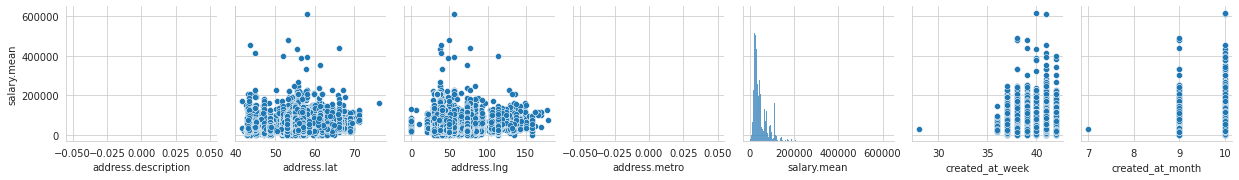

In [171]:
float_cols = df.select_dtypes('float64').columns.to_list()
int_cols = df.select_dtypes('int64').columns.to_list()
num_cols = float_cols + int_cols
pp = sns.pairplot(data=df,
                  y_vars=['salary.mean'],
                  x_vars=num_cols)

In [172]:
import plotly.graph_objects as go


fig = go.Figure(data=go.Scattergeo(
        lon = df['address.lng'],
        lat = df['address.lat'],
        text = df['area.name'],
        mode = 'markers',
        marker_color = df['salary.mean'],
        ))

fig.update_layout(
        title = 'Средняя зарплата',
        geo_scope='world',
    )
fig.show()